# <font color=black> Analysis - FC-based parcellation using correlation </font>
<hr style="border:1px solid black">

In [2]:
import sys,json
import glob, os
import numpy as np
import nibabel as nib
import time
from nilearn import datasets, plotting, image, surface
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import pandas as pd

sys.path.append('/media/miplab-nas2/Data3/BMPD/hc_project/analysis/code/')

from fc_based_parcellation import FC_Parcellation

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Initialization
<hr style="border:0.5px solid black">

In [3]:
# Import masks (levels, LR, DV)
L_img = nib.load('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_cord_L.nii.gz')
L = L_img.get_fdata()
R_img = nib.load('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_cord_R.nii.gz')
R = R_img.get_fdata()
D_img = nib.load('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_cord_D.nii.gz')
D = D_img.get_fdata()
V_img = nib.load('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_cord_V.nii.gz')
V = V_img.get_fdata()
LR = L+R*2
DV = D+V*2
levels_img = nib.load('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_spinal_levels_C1C7.nii.gz')
levels = levels_img.get_fdata()
mask_img = nib.load('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_gm_bin07_C1C7.nii.gz')
mask = mask_img.get_fdata().astype(bool)

levels_masked = levels[mask]
print(levels_masked.shape)
levels_vec = levels_masked.flatten()[levels_masked.flatten() > 0]
print(levels_vec.shape)

LR_masked = LR[mask]
print(LR_masked.shape)
LR_vec = LR_masked.flatten()[LR_masked.flatten() > 0]
print(LR_vec.shape)

DV_masked = DV[mask]
print(DV_masked.shape)
DV_vec = DV_masked.flatten()[DV_masked.flatten() > 0]
print(DV_vec.shape)


(9000,)
(9000,)
(9000,)
(8658,)
(9000,)
(7118,)


In [7]:
# Load FC
fc=np.zeros((31,9000,14343))
for sub_id,sub in enumerate(["P030", "P099","A006","A007","A008","A009","A011","A013","A023","A024","A025","A026","A027","A028","A029","A030","A032","A033","A034","A036","A037","A038","A039","A043","A044","A045","A046","A048","A050","A051","A052"]):
    fc[sub_id,:,:]=np.load('/media/miplab-nas2/Data3/BMPD/hc_project/brain_spine/results/fc_parcellation/corr/C1toC7_gm_07_notsmoothed_to_iCAP_SMC/fcs/C1toC7_gm_07_notsmoothed_to_iCAP_SMC_' + sub + '_corr.npy')

In [4]:
# Prepare ordered levels
levels_vec = levels_vec.astype(int)
levels_order = np.argsort(levels_vec)

In [8]:
# Compute similarity between FC profiles
corr_all=np.zeros((31,9000,9000))
for sub_id,sub in enumerate(["P030", "P099","A006","A007","A008","A009","A011","A013","A023","A024","A025","A026","A027","A028","A029","A030","A032","A033","A034","A036","A037","A038","A039","A043","A044","A045","A046","A048","A050","A051","A052"]):
    corr_all[sub_id,:,:] = np.corrcoef(fc[sub_id,:,:])

In [9]:
# Compute means
fc_mean = np.mean(fc,axis=0)
sim_mean = np.mean(corr_all,axis=0)

In [10]:
# Save arrays
np.save('/media/miplab-nas2/Data3/BMPD/hc_project/fc_mean_notsmoothed.npy',fc_mean)
np.save('/media/miplab-nas2/Data3/BMPD/hc_project/sim_mean_notsmoothed.npy',sim_mean)

In [5]:
fc_mean=np.load('/media/miplab-nas2/Data3/BMPD/hc_project/fc_mean.npy')
sim_mean=np.load('/media/miplab-nas2/Data3/BMPD/hc_project/sim_mean.npy')

In [102]:
sim_mean_sorted_ds.shape

(900, 900)

In [6]:
# Reorder and downsample
levels_sorted = levels_vec[levels_order]
levels_sorted_ds = levels_sorted[::10]
levels_sorted_ds_inv = levels_sorted_ds[::-1]

sim_mean_sorted = sim_mean[levels_order,:]
sim_mean_sorted = sim_mean_sorted[:,levels_order]
sim_mean_sorted_ds = sim_mean_sorted[::10,::10]
sim_mean_sorted_ds_inv = sim_mean_sorted_ds[::-1,::-1]

fc_mean_sorted = fc_mean[levels_order,:]
fc_mean_sorted_ds = fc_mean_sorted[::10,:]

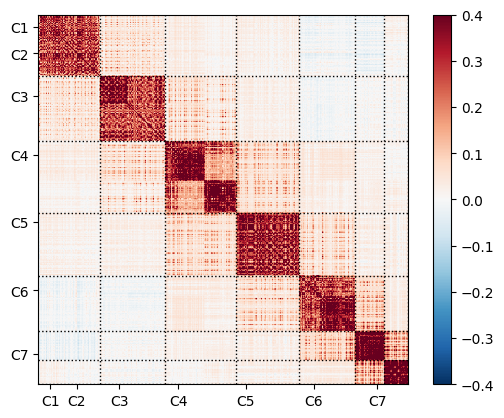

In [7]:
# Plot similarity matrix to check
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the reordered matrix
img = ax.imshow(sim_mean_sorted_ds_inv, cmap='RdBu_r', vmin=-0.4, vmax=0.4)

# Customize x and y axis ticks
unique_levels, counts = np.unique(levels_sorted_ds_inv, return_counts=True)
x_label_positions = np.cumsum(counts) - counts / 2
y_label_positions = x_label_positions

# Use a dictionary for tick labels
label_mapping = {1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7'}
tick_labels = [label_mapping[level] for level in unique_levels]

# Add vertical/horizontal lines
line_positions = [np.where(levels_sorted_ds_inv == level)[0][-1] for level in unique_levels]
for x_pos, y_pos in zip(line_positions, line_positions):
    ax.axvline(x_pos, color='black', linestyle=':', linewidth=1)
    ax.axhline(y_pos, color='black', linestyle=':', linewidth=1)

# Add ticks at the center of each region
ax.set_xticks(x_label_positions)
ax.set_yticks(y_label_positions)

# Set tick labels
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

# Display colorbar
plt.colorbar(img)

# Show the plot
plt.show()

In [12]:
# Define the Spectral colormap from matplotlib
cmap = plt.get_cmap('Spectral')

# Define the number of colors needed (in this case, 7)
num_colors = 7

# Get the colors from the colormap
colors = [cmap(i / num_colors) for i in range(num_colors)]

# Create a dictionary mapping each unique value to a color
color_mapping = {i + 1: colors[i] for i in range(num_colors)}

# Map each value in levels_cut to its corresponding color
level_colors = [color_mapping[value] for value in levels_vec]

In [ ]:
# Define the Spectral colormap from matplotlib
cmap = plt.get_cmap('Rainbow')

# Get the colors from the colormap
colors = [cmap(i / num_colors) for i in range(num_colors)]

# Create a dictionary mapping each unique value to a color
color_mapping = {i + 1: colors[i] for i in range(num_colors)}


# Clustering
<hr style="border:0.5px solid black">

In [13]:
upper_triangular = sim_mean[np.triu_indices(sim_mean.shape[0], k=1)]
DF_dism = 1-upper_triangular

linkage = hc.linkage(DF_dism, method='average',optimal_ordering=True)                   
kvalues = hc.cut_tree(linkage, n_clusters=7)
k_colors = [color_mapping[value] for value in kvalues.flatten()+1]

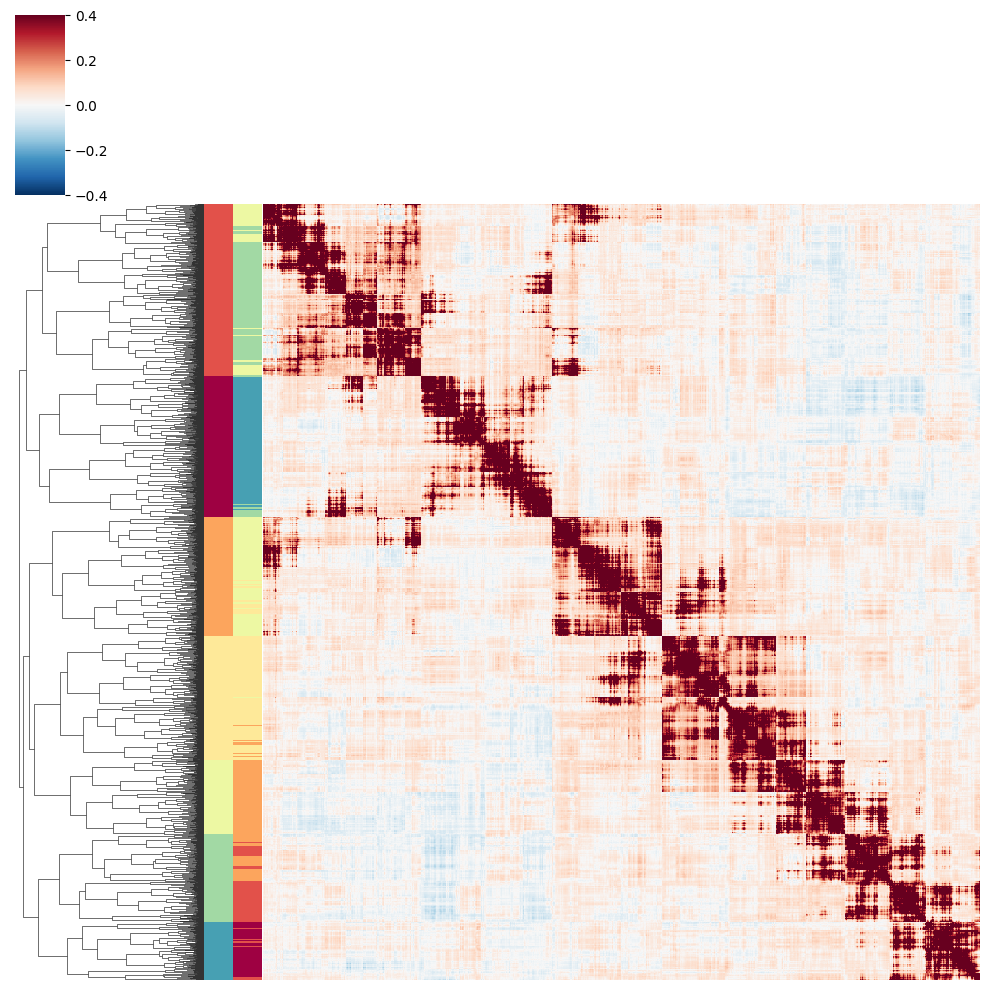

In [14]:
g=sns.clustermap(sim_mean, row_linkage=linkage, row_colors=[k_colors,level_colors], col_linkage=linkage, cmap='RdBu_r', vmin=-0.4, vmax=0.4,square=True,xticklabels=False,yticklabels=False)
g.ax_col_dendrogram.set_visible(False)


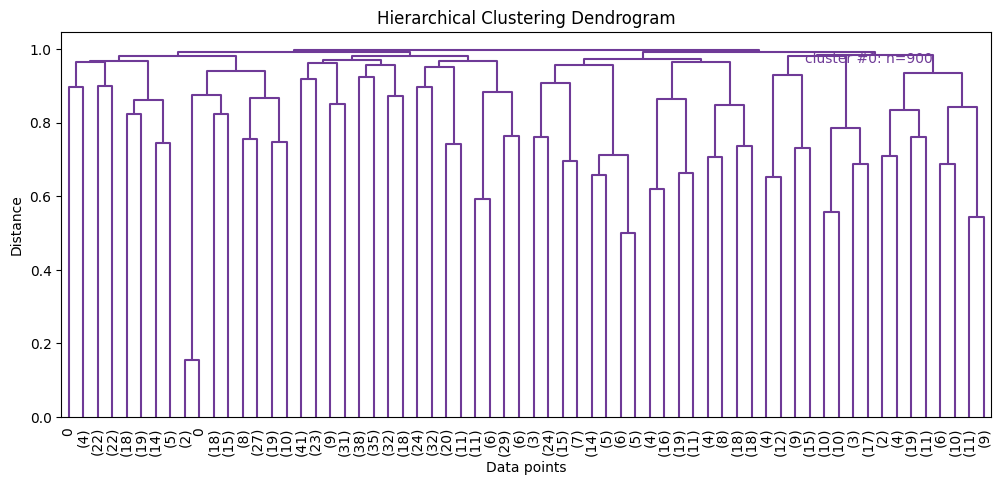

In [49]:
import random 

g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((0.8, .2, .03, .4))def rgb_hex(color):
    '''converts a (r,g,b) color (either 0-1 or 0-255) to its hex representation.
    for ambiguous pure combinations of 0s and 1s e,g, (0,0,1), (1/1/1) is assumed.'''
    message='color must be an iterable of length 3.'
    assert hasattr(color, '__iter__'), message
    assert len(color)==3, message
    if all([(c<=1)&(c>=0) for c in color]): color=[int(round(c*255)) for c in color] # in case provided rgb is 0-1
    color=tuple(color)
    return '#%02x%02x%02x' % color

def generate_random_color():
    r = random.randint(0, 255)  # Random value for red component
    g = random.randint(0, 255)  # Random value for green component
    b = random.randint(0, 255)  # Random value for blue component
    return [r, g, b]

# Generate 10 random RGB colors
colors = [generate_random_color() for _ in range(10)]
default_color=[0.5,0.5,0.5]

def get_cluster_colors(n_clusters, my_set_of_20_rgb_colors, alpha=0.8, alpha_outliers=0.05):
    cluster_colors = my_set_of_20_rgb_colors
    cluster_colors = [c+[alpha] for c in cluster_colors]
    outlier_color = [0,0,0,alpha_outliers]
    return [cluster_colors[i%19] for i in range(n_clusters)] + [outlier_color]


# perform hierarchical clustering
Z = linkage
threshold = 7 
# get cluster labels
labels         = hc.fcluster(Z, threshold, criterion='distance') - 1
labels_str     = [f"cluster #{l}: n={c}\n" for (l,c) in zip(*np.unique(labels, return_counts=True))]
n_clusters     = len(labels_str)

cluster_colors = [rgb_hex(c[:-1]) for c in get_cluster_colors(n_clusters, my_set_of_20_rgb_colors=colors, alpha=0.8, alpha_outliers=0.05)]
cluster_colors_array = [cluster_colors[l] for l in labels]
link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
    c1, c2 = (link_cols[x] if x > len(Z) else cluster_colors_array[x] for x in i12)
    link_cols[i+1+len(Z)] = c1 if c1 == c2 else 'k'

# plot dendrogram with colored clusters
fig = plt.figure(figsize=(12, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')

# plot dendrogram based on clustering results
hc.dendrogram(Z,
              labels = labels,
              color_threshold=threshold,
              truncate_mode = 'level',
              p = 5,
              leaf_rotation=90,
              leaf_font_size=10,
              show_contracted=False,
              link_color_func=lambda x: link_cols[x],
              ax=plt.gca()
    )
plt.axhline(threshold, color='k')
for i, s in enumerate(labels_str):
    plt.text(0.8, 0.95-i*0.04, s,
                transform=plt.gca().transAxes,
                va='top', color=cluster_colors[i])
    
fig.patch.set_facecolor('white')

In [ ]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy

corr_mean = np.mean(corr_all,axis=0)
corr_mean_r = corr_mean[levels_order,:]
corr_mean_r = corr_mean_r[:,levels_order]
dist_mean_r = 1-corr_mean_r
upper_triangle = np.triu(dist_mean_r, k=1)

# If you want to convert it to a flat array:
flat_upper_triangle = upper_triangle[np.triu_indices(upper_triangle.shape[0], k=1)]

Z = linkage(flat_upper_triangle, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [35]:
fc_mean = np.mean(fc,axis=0)

In [7]:
corr_mean = np.mean(corr_all,axis=0)
corr_mean_r = corr_mean[levels_order,:]
corr_mean_r = corr_mean_r[:,levels_order]
dist_mean_r = 1-corr_mean_r
upper_triangle = np.triu(dist_mean_r, k=1)

In [52]:
toplot = corr_all[0,:,:]
toplot_r = toplot[levels_order,:]
toplot_r = toplot_r[:,levels_order]

In [58]:
corr_mean_r.dtype.char 

'd'

In [57]:
toplot_r.dtype.char 

'd'

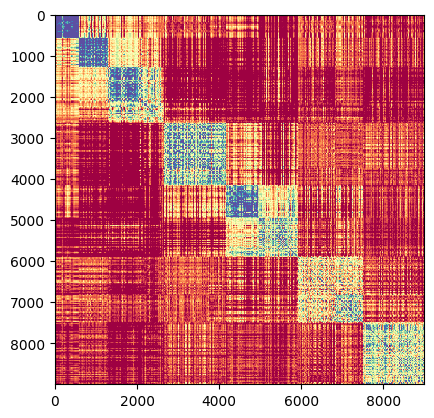

In [53]:
plt.imshow(toplot_r, cmap='Spectral', vmin=0, vmax=0.5)

In [62]:
corr1 = corr_all[0,:,:]
corr1_r = corr1[levels_order,:]
corr1_r = corr1_r[:,levels_order]
dist1_r=1-corr1_r

In [16]:
seed = NiftiMasker('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_gm_bin07_C1C7.nii.gz').fit()
sub_lbl = np.load('/media/miplab-nas2/Data3/BMPD/hc_project/brain_spine/results/fc_parcellation/corr/C1toC7_gm_07_to_wholebrain/source/sim/K7/indiv_labels/C1toC7_gm_07_to_wholebrain_A023_agglom_labels_k7.npy')
labels_img = seed.inverse_transform(sub_lbl+1) # +1 because labels start from 0 
labels_img.to_filename('/media/miplab-nas2/Data3/BMPD/hc_project/sub-023.nii.gz')
  

In [13]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from nilearn.maskers import NiftiMasker

#corr_mean = np.mean(corr_all,axis=0)
#fc=np.load('/media/miplab-nas2/Data3/BMPD/hc_project/brain_spine/results/fc_parcellation/corr/C1toC7_gm_07_to_wholebrain/fcs/C1toC7_gm_07_to_wholebrain_P030_corr.npy')
#corr_mean = np.corrcoef(fc)
#corr_mean = np.mean(corr_all,axis=0)
#corr_mean_r = corr_mean[levels_order,:]
#corr_mean_r = corr_mean_r[:,levels_order]
#dist_mean_r = 1-corr_mean_r
#dist_mean = 1-corr_mean
sim_A006 = corr_all[0,:,:]

#sil = np.zeros((len(range(2,15)),1))
#for k_ind,k in enumerate(range(2,15)):
cluster = AgglomerativeClustering(n_clusters=7, metric='precomputed', linkage='average')
cluster.fit(sim_A006)

seed = NiftiMasker('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_gm_bin07_C1C7.nii.gz').fit()
labels_img = seed.inverse_transform(cluster.labels_+1) # +1 because labels start from 0 
labels_img.to_filename('/media/miplab-nas2/Data3/BMPD/hc_project/todel_agglom_cos_avg_iCAP_SMC_fcmean_k7.nii.gz')
                
#sil[k_ind] = silhouette_score(corr_mean_r, cluster.labels_)


/home/kinany/anaconda3/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nilearn.maskers import NiftiMasker

#corr_mean = np.mean(corr_all,axis=0)
#fc=np.load('/media/miplab-nas2/Data3/BMPD/hc_project/brain_spine/results/fc_parcellation/corr/C1toC7_gm_07_to_wholebrain/fcs/C1toC7_gm_07_to_wholebrain_P030_corr.npy')
#corr_mean = np.corrcoef(fc)
corr_mean = np.mean(corr_all,axis=0)
#corr_mean_r = corr_mean[levels_order,:]
#corr_mean_r = corr_mean_r[:,levels_order]
#dist_mean_r = 1-corr_mean_ra
#dist_mean = 1-corr_mean
#fc_mean=np.mean(fc,axis=0)
#dist_mean = squareform(pdist(fc_mean,'euclidean'))

#sil = np.zeros((len(range(2,15)),1))
#for k_ind,k in enumerate(range(2,15)):
cluster = KMeans(n_clusters=7,init='k-means++')
cluster.fit(dist_mean)

seed = NiftiMasker('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_gm_bin07_C1C7.nii.gz').fit()
labels_img = seed.inverse_transform(cluster.labels_+1) # +1 because labels start from 0 
labels_img.to_filename('/media/miplab-nas2/Data3/BMPD/hc_project/todel_kmeans_iCAP_SMC_mean_k7n.nii.gz')
                
#sil[k_ind] = silhouette_score(corr_mean_r, cluster.labels_)


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [4]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from nilearn.maskers import NiftiMasker
from scipy.spatial.distance import pdist, squareform

#corr_mean = np.mean(corr_all,axis=0)
#fc=np.load('/media/miplab-nas2/Data3/BMPD/hc_project/brain_spine/results/fc_parcellation/corr/C1toC7_gm_07_to_wholebrain/fcs/C1toC7_gm_07_to_wholebrain_P030_corr.npy')
#corr_mean = np.corrcoef(fc)
#corr_mean = np.mean(corr_all,axis=0)
#corr_mean_r = corr_mean[levels_order,:]
#corr_mean_r = corr_mean_r[:,levels_order]
#dist_mean_r = 1-corr_mean_ra
#dist_mean = 1-corr_mean
#fc_mean=np.mean(fc,axis=0)
#dist_mean = squareform(pdist(fc_mean,'euclidean'))

#sil = np.zeros((len(range(2,15)),1))
#for k_ind,k in enumerate(range(2,15)):
cluster = AgglomerativeClustering(n_clusters=7, metric='precomputed', linkage='average')
cluster.fit(dist_mean)

seed = NiftiMasker('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_gm_bin07_C1C7.nii.gz').fit()
labels_img = seed.inverse_transform(cluster.labels_+1) # +1 because labels start from 0 
labels_img.to_filename('/media/miplab-nas2/Data3/BMPD/hc_project/todel_average_iCAP_SMC_mean_k7_euclidean.nii.gz')
                
#sil[k_ind] = silhouette_score(corr_mean_r, cluster.labels_)


/home/kinany/anaconda3/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


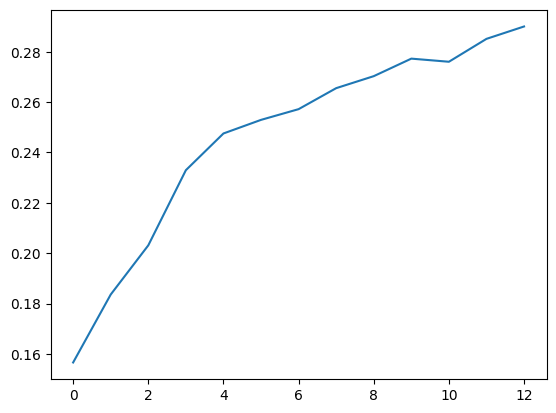

In [59]:
plt.plot(sil)

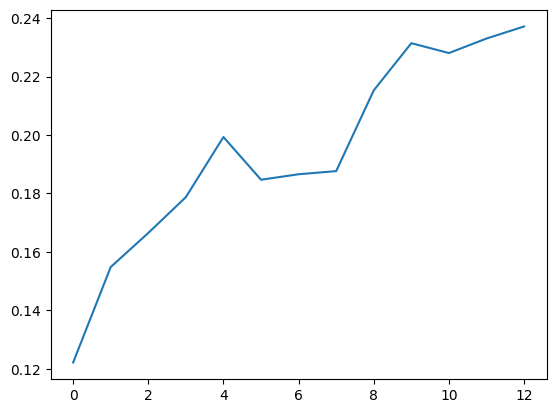

In [45]:
plt.plot(sil)

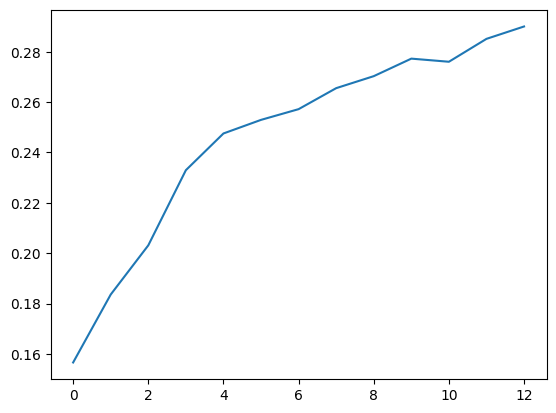

In [39]:
plt.plot(sil)

In [20]:
labels_script=np.load('/media/miplab-nas2/Data3/BMPD/hc_project/brain_spine/results/fc_parcellation/corr/C1toC7_gm_07_to_wholebrain/source/sim/K7/group_labels/C1toC7_gm_07_to_wholebrain_agglom_group_labels_mode_k7.npy')

In [23]:
print(adjusted_mutual_info_score(levels_sorted,labels_script[levels_order]))

0.6954828361747984


In [15]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
levels_sorted = levels_vec[levels_order]
c=cluster.labels_+1
print(adjusted_mutual_info_score(labels_script,levels_sorted))

0.6771183332763677


In [18]:
import pandas as pd
validity = pd.read_pickle('/media/miplab-nas2/Data3/BMPD/hc_project/brain_spine/results/fc_parcellation/corr/C1toC7_gm_07_to_wholebrain/source/sim/validity/C1toC7_gm_07_to_wholebrain_agglom_internal_validity.pkl')

In [16]:
validity_new = validity[validity['sub']!='A007']

In [19]:
validity

,sub,SSE,silhouette,davies,calinski,k
0,P030,0,0.163037,1.916498,2403.219795,2
1,P030,0,0.160102,1.690779,1700.272112,3
2,P030,0,0.191136,1.549410,1915.976421,4
3,P030,0,0.233933,1.609477,2076.187365,5
4,P030,0,0.255835,1.609565,1901.319343,6
5,P030,0,0.259959,1.547293,1809.296925,7
6,P030,0,0.272324,1.454800,1705.348114,8
7,P030,0,0.286231,1.392982,1590.999650,9
8,P030,0,0.300395,1.401077,1637.814419,10
9,P030,0,0.310900,1.397797,1599.004019,11


In [12]:
# Calculate the correlation matrix
corrmat = np.corrcoef(fc_mean)
corrmat_r = corrmat[levels_sorted,:]
corrmat_r = corrmat_r[:,levels_sorted]
plt.imshow(corrmat_r,cmap='bwr', vmin=-0.5, vmax=0.5)
plt.colorbar()

NameError: name 'fc_mean' is not defined

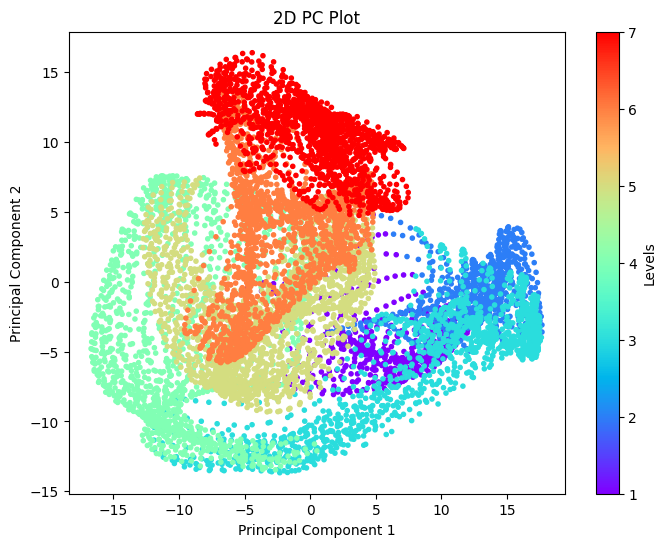

In [60]:
from sklearn.decomposition import PCA
from scipy.stats import zscore

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(corr_mean_r)

# Create a 2D PC plot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=levels_sorted, cmap='rainbow', marker='.')

# Set axis labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# Set plot title
ax.set_title('2D PC Plot')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Levels')

# Show the plot
plt.show()

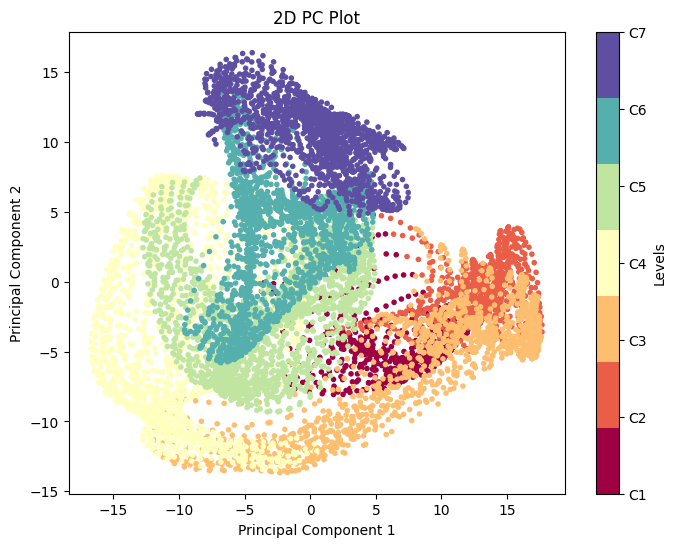

In [94]:
from sklearn.decomposition import PCA
from scipy.stats import zscore

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(corr_mean_r)

# Create a 2D PC plot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot
cmap = plt.get_cmap('Spectral', np.max(levels_sorted) - np.min(levels_sorted) + 1)
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=levels_sorted, cmap=cmap, marker='.')

# Set axis labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# Set plot title
ax.set_title('2D PC Plot')
# Add custom colorbar with evenly spaced ticks
cbar = plt.colorbar(scatter, ticks=np.linspace(0, num_colors, num_colors+1), format='%1.1f')

level_names = [f'C{int(level)}' for level in range(0, num_colors + 1)]
cbar.set_ticklabels(level_names)

cbar.set_label('Levels')

# Show the plot
plt.show()

/tmp/ipykernel_121688/2134036703.py:25: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(scatter)


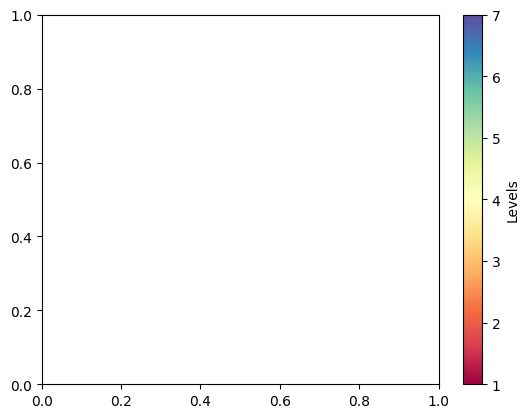

In [51]:
from sklearn.decomposition import PCA
from scipy.stats import zscore

pca = PCA(n_components=3)
pca_result = pca.fit_transform(corr_mean_r)

# Create a 3D PC plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=levels_sorted, cmap='Spectral', marker='.')

# Set axis labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set plot title
ax.set_title('3D PC Plot')
# Enable 3D rotation tool
ax.view_init(elev=20, azim=30)  # Set the initial view

# Show the plot
plt.show()

In [59]:
start = time.time()
# Loop through the subjects to compute fc and clustering 
for sub_id,sub in enumerate(fc_parcellation.config['list_subjects']): 
    print(f'\033[1mSUBJECT {sub}\033[0m')
    # Compute correlation without saving files
    fc_parcellation.compute_voxelwise_fc(sub=sub, 
                                        overwrite=False)
    # Run clustering and save labels
    fc_parcellation.run_clustering(sub=sub,
                                    k_range=7,algorithm='spectral',
                                    overwrite=False)
print("\033[1m... Operation performed in %.2f s!\033[0m" % (time.time() - start))

SUBJECT P030
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... Loading data
... Computing FC for all possibilities
... Metric: correlation
... Fisher transforming correlations

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = spectral
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running spectral clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(




SUBJECT P099
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... Loading data
... Computing FC for all possibilities
... Metric: correlation
... Fisher transforming correlations

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = spectral
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running spectral clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(




SUBJECT A006
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... Loading data
... Computing FC for all possibilities
... Metric: correlation
... Fisher transforming correlations

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = spectral
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running spectral clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(




SUBJECT A007
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... Loading data
... Computing FC for all possibilities
... Metric: correlation
... Fisher transforming correlations

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = spectral
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running spectral clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(




SUBJECT A008
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... Loading data
... Computing FC for all possibilities
... Metric: correlation
... Fisher transforming correlations

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = spectral
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running spectral clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

### Compute the group-level clustering and generate corresponding maps

In [ ]:
fc_parcellation.group_clustering(k_range=7,indiv_algorithm='spectral',overwrite=False)

In [ ]:
fc_parcellation.prepare_target_maps(label_type='indiv',indiv_algorithm='spectral',k_range=7,overwrite=False)

In [ ]:
fc_parcellation.prepare_target_maps(label_type='group_mode',indiv_algorithm='spectral',k_range=7,overwrite=False)

### Statistics and WTA analysis

In [51]:
fc_parcellation.stats_target_maps(label_type='indiv',indiv_algorithm='spectral',k_range=8,overwrite=False)

RUN STATISTICAL ANALYSIS
Type of source labels = indiv
K value(s) = 8
Overwrite results = False
K = 8
... Merging target files
fslmerge -t /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_to_C1toC7_gm_D_nofilter/target//K8/indiv_labels/maps_indiv/postcentral_to_C1toC7_gm_D_nofilter_all_spectral_indiv_labels_targetmap_K8_1.nii.gz /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_to_C1toC7_gm_D_nofilter/target//K8/indiv_labels/maps_indiv/postcentral_to_C1toC7_gm_D_nofilter_*_spectral_indiv_labels_targetmap_K8_1.nii.gz
... Running statistical analysis
randomise options: -i /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_to_C1toC7_gm_D_nofilter/target//K8/indiv_labels/maps_indiv/postcentral_to_C1toC7_gm_D_nofilter_all_spectral_indiv_labels_targetmap_K8_1.nii.gz -m /media/miplab-nas2/Data3/BMPD/hc_project//analysis/masks/spinalcord/PAM50_C1C7_gm_D.nii.

... Running statistical analysis
randomise options: -i /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_to_C1toC7_gm_D_nofilter/target//K8/indiv_labels/maps_indiv/postcentral_to_C1toC7_gm_D_nofilter_all_spectral_indiv_labels_targetmap_K8_7.nii.gz -m /media/miplab-nas2/Data3/BMPD/hc_project//analysis/masks/spinalcord/PAM50_C1C7_gm_D.nii.gz -o /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_to_C1toC7_gm_D_nofilter/target//K8/indiv_labels/stats/spectral/K8_7 -1 
Loading Data: 
Data loaded
One-sample design detected; sign-flipping instead of permuting.
2.14748e+09 sign-flips required for exhaustive test of t-test 1
Doing 5000 random permutations
Warning! No output options selected. Outputing raw tstat only
Starting permutation 1 (Unpermuted data)
Finished, exiting.
... Merging target files
fslmerge -t /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_

In [52]:
fc_parcellation.winner_takes_all(label_type='indiv',indiv_algorithm='spectral',apply_threshold=1,k=8, overwrite=True)

RUN WINNER-TAKES-ALL ANALYSIS
Type of source labels = indiv
K value = 8
Overwrite results = True
K1 will have a value of 1
K2 will have a value of 2
K3 will have a value of 3
K4 will have a value of 4
K5 will have a value of 5
K6 will have a value of 6
K7 will have a value of 7
K8 will have a value of 8


/home/kinany/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


DONE



/home/kinany/anaconda3/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


# Plotting
<hr style="border:0.5px solid black">

### WTA maps

RUN PLOTTING BRAIN MAPS
K value = 8
Showing = source
Save figure = True
Source labels are not re-ordered!


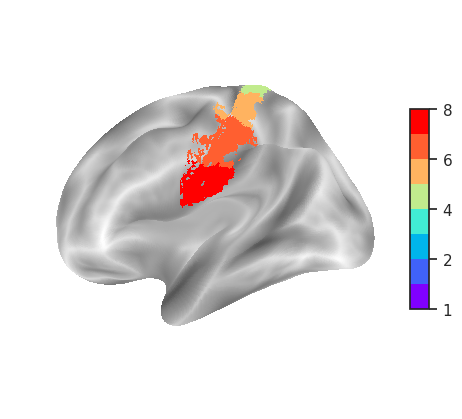

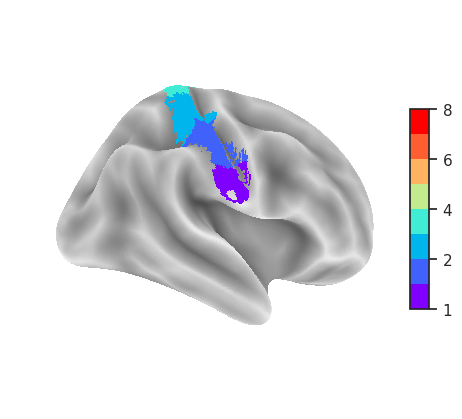

In [53]:
fc_parcellation.plot_brain_map(showing='source',indiv_algorithm='spectral', k=8, save_figure=True)

### Plot label maps

RUN PLOTTING SPINAL MAPS
K value = 8
Showing = target
Save figure = True
The plotting is displayed in neurological orientation (Left > Right)


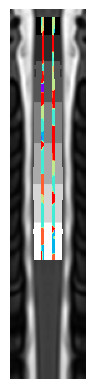

In [55]:
fc_parcellation.plot_spinal_map(showing='target',label_type='indiv',k=8, slice_y=24,indiv_algorithm='spectral', save_figure=True)

### Validity
<hr style="border:0.5px solid black">

### Plot validity metrics

VALIDITY METRICS
K value(s) = range(2, 10)
Saving figures = True



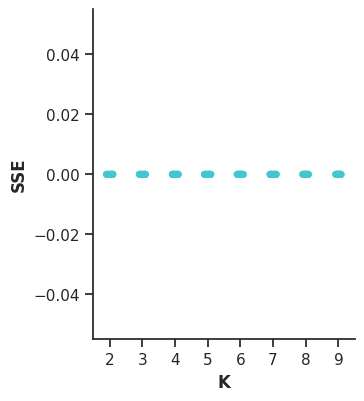

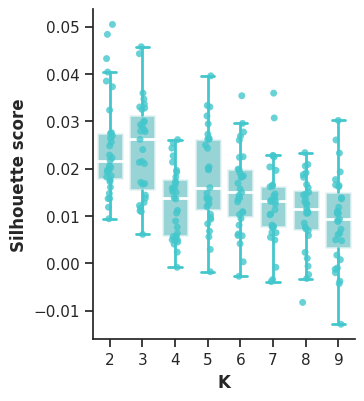

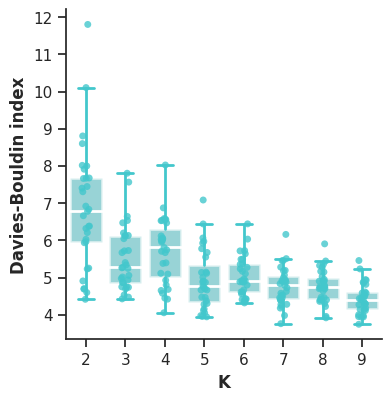

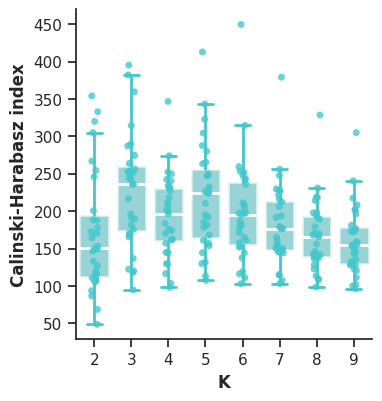

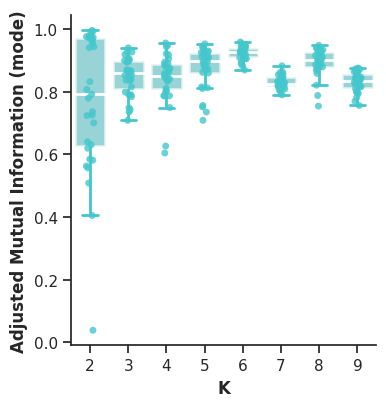

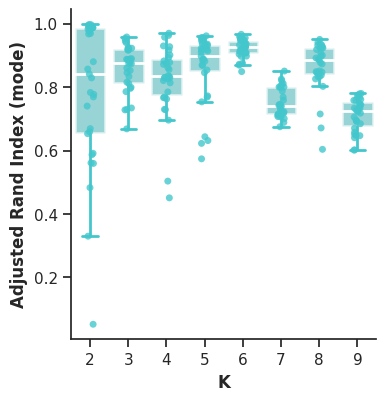

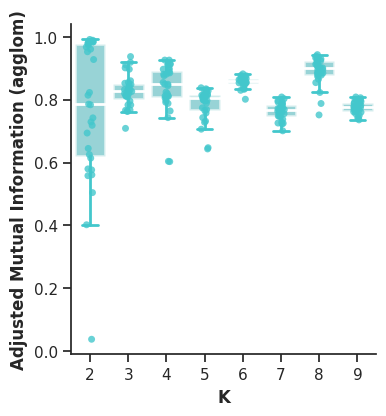

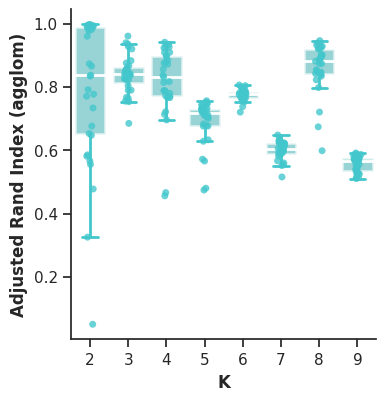

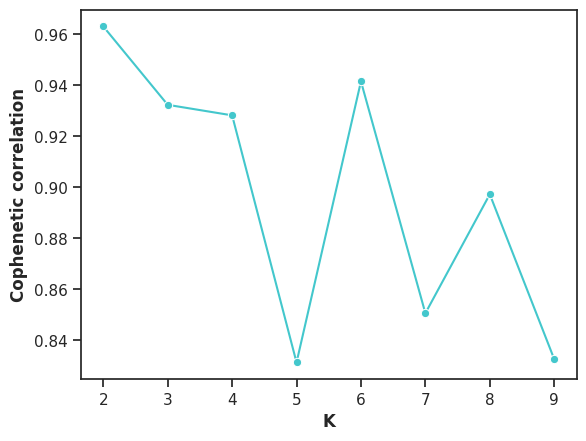

In [44]:
fc_parcellation.plot_validity(k_range=range(2,10),indiv_algorithm='spectral',internal=["SSE", "silhouette", "davies", "calinski"], group=["ami_mode", "ari_mode","ami_agglom", "ari_agglom", "corr"], save_figures=True)